# PyTorch Image Classification

In [ ]:
pip install timer

In [ ]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import timer
from torchvision.transforms import v2

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data.sampler import SubsetRandomSampler
from timeit import default_timer as timer
from torchsummary import summary

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


## Getting a dataset

In [ ]:
transforms = v2.Compose([
    ToTensor()
])

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",  # where to download data to?
    train=True,  # get training data
    download=True,  # download data if it doesn't exist on disk
    transform=transforms,  # images come as PIL format, we want to turn into Torch tensors
    target_transform=None,  # you can transform labels as well
)

train_data_len = len(train_data)
TRAIN_SPLIT = int(train_data_len * 0.9)
VAL_SPLIT = int(train_data_len * 0.1)

train_data, val_data = torch.utils.data.random_split(train_data, [TRAIN_SPLIT, VAL_SPLIT])

# Setup testing data
test_data = datasets.FashionMNIST(root="data", train=False, download=True, transform=transforms)  # get test data


100%|██████████| 26.4M/26.4M [00:01<00:00, 18.9MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 17.6MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Let's check out the first sample of the training data.

In [ ]:
# See first training sample
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:
# What's the shape of the image?
image.shape

torch.Size([1, 28, 28])

In [ ]:
# See classes
class_names = test_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### Visualizing our data

Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, '8')

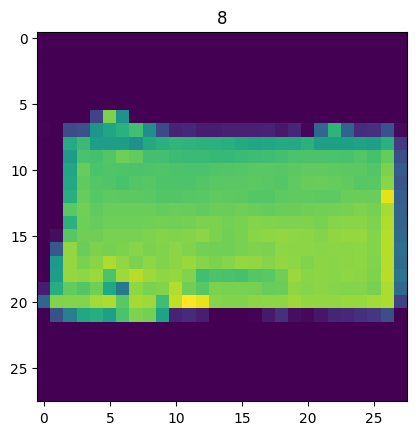

In [ ]:
import matplotlib.pyplot as plt

image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze())  # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label)

Text(0.5, 1.0, 'Bag')

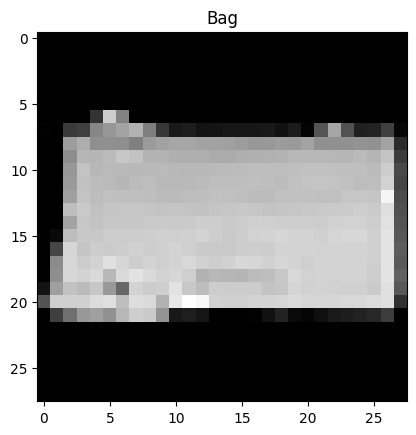

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

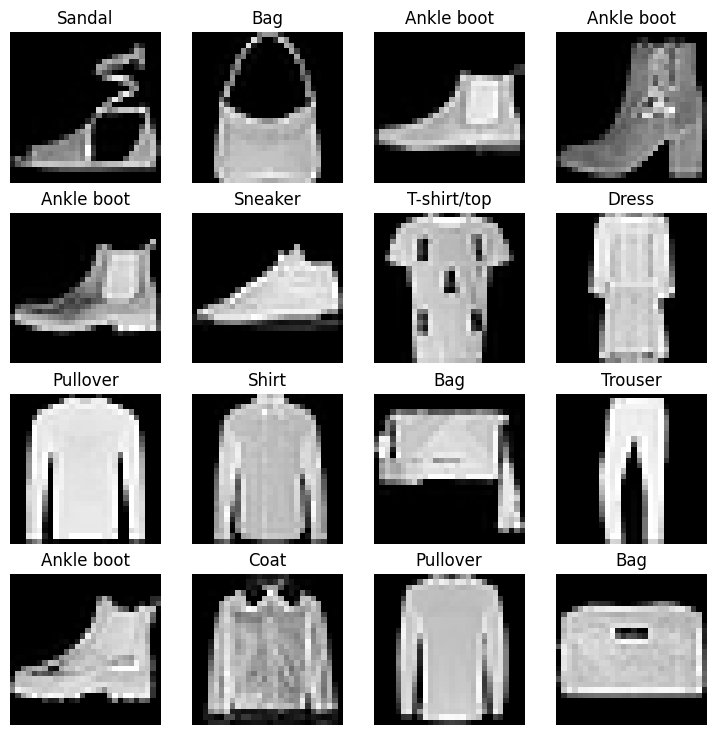

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## Prepare DataLoader

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7d9484266ad0>, <torch.utils.data.dataloader.DataLoader object at 0x7d9484083a50>)
Length of train dataloader: 1688 batches of 32
Length of test dataloader: 313 batches of 32


In [ ]:
len(train_data), len(train_dataloader)

(54000, 1688)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [ ]:
train_labels_batch

tensor([0, 0, 6, 7, 7, 9, 0, 1, 2, 5, 0, 4, 9, 9, 9, 3, 9, 6, 7, 4, 7, 3, 0, 9,
        8, 3, 4, 1, 1, 0, 3, 5])

Image size: torch.Size([1, 28, 28])
Label: 0, label size: torch.Size([])


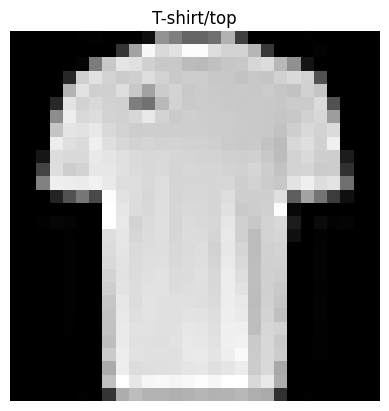

In [ ]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off")
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),  # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

### Training and test loops

In [ ]:
def train_step(model, data_loader, loss_fn, optimizer, device):

    model.train()

    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return train_loss / len(data_loader), train_acc / len(data_loader)


def test_step(model, data_loader, loss_fn, device):

    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    return test_loss / len(data_loader), test_acc / len(data_loader)

def train(model,
          train_data_loader,
          test_data_loader,
          optimizer,
          loss_fn,
          epochs,
          device):

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
        }

    model.to(device)

    for epoch in tqdm(range(epochs)):

        start_time = timer()
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_data_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )
        end_time = timer()

        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            device=device,
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f} | "
            f"time: {(end_time-start_time):.4f}"
        )

    return results

In [ ]:
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [ ]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV1(
    input_shape=28*28,  # number of input features
    hidden_units=10,
    output_shape=len(class_names),  # number of output classes desired
).to(device)  # send model to GPU if it's available
next(model_0.parameters()).device  # check model device

device(type='cuda', index=0)

In [ ]:
summary(model_0.to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 10]           7,850
              ReLU-3                   [-1, 10]               0
            Linear-4                   [-1, 10]             110
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.03
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [ ]:
results = train(
    model=model_0,
    train_data_loader=train_dataloader,
    test_data_loader=val_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=3,
    device=device,
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0909 | train_acc: 63.1739 | test_loss: 0.6940 | test_acc: 76.8451 | time: 7.7451
Epoch: 2 | train_loss: 0.6224 | train_acc: 78.7322 | test_loss: 0.5921 | test_acc: 79.1223 | time: 7.4700
Epoch: 3 | train_loss: 0.5482 | train_acc: 81.0501 | test_loss: 0.5298 | test_acc: 81.2500 | time: 7.4912


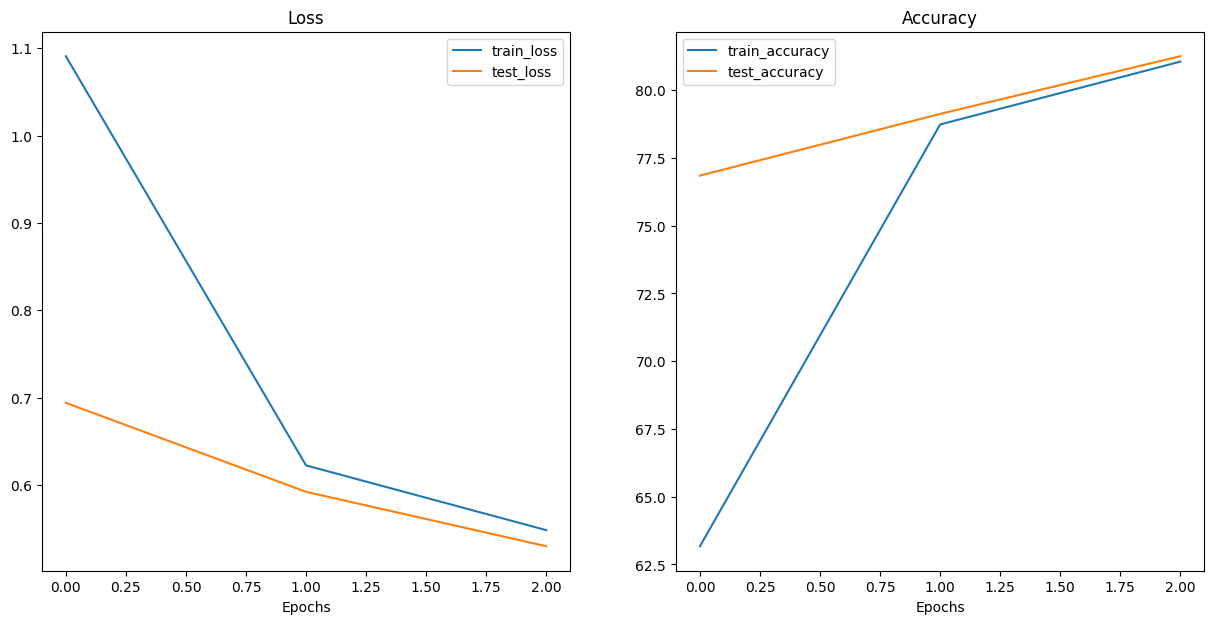

In [ ]:
plot_loss_curves(results)

In [ ]:
test_step(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, device=device)

(0.5589192854329801, 80.01198083067092)

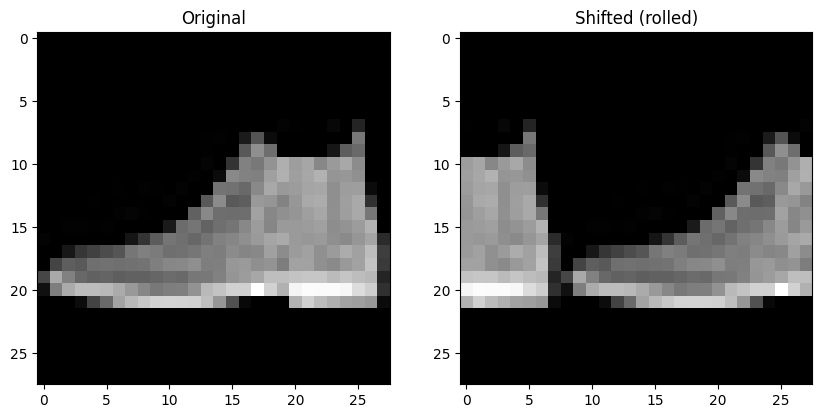

In [ ]:
# first let's see how to shift a vectorized image

# grab one image data
tmp = test_dataloader.dataset.data[0,:]
tmp = tmp.reshape(28,28) # reshape to 2D image

# shift the image (pytorch calls it "rolling")
tmpS = torch.roll(tmp,8,dims=1)

# now show them both
fig,ax = plt.subplots(1,2,figsize=(10,6))
ax[0].imshow(tmp, cmap='gray')
ax[0].set_title('Original')

ax[1].imshow(tmpS, cmap='gray')
ax[1].set_title('Shifted (rolled)')

plt.show()

In [ ]:
for i in range(test_dataloader.dataset.data.shape[0]):

    # get the image
    img = test_dataloader.dataset.data[i,:]

    # reshape and roll by max. 10 pixels
    randroll = np.random.randint(-10,11)
    img = torch.roll( img.reshape(28,28) ,randroll,dims=1 )

    # re-vectorize and put back into the matrix
    test_dataloader.dataset.data[i,:] = img

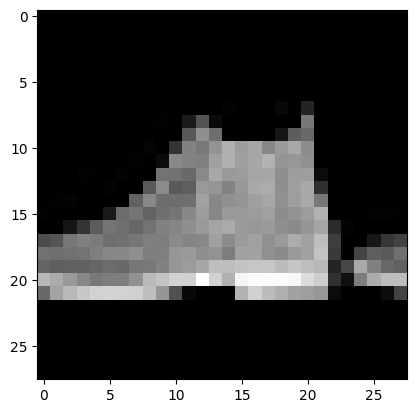

In [ ]:
for i in range(test_dataloader.dataset.data.shape[0]):

    # get the image
    img = test_dataloader.dataset.data[i,:]
    plt.imshow(img.squeeze(), cmap="gray")

    plt.show()
    break

In [ ]:
test_step(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, device=device)

(3.911789588654003, 32.248402555910545)